# MACHINE LEARNING PROJECT

# Steps

1. Importing the libraries and loading the data
2. Exploration of the dataset 
3. Features engineering
4. Missing values 
5. Encoding categorical features
6. Outliers
7. Index
8. Feature selection
9. Modeling

Possibilities considered

3 approaches for nan:
- knn imputer
- dropping them
- fill with the mode

2 approaches for outliers
- leave them
- drop them

Models:
- gradient boosting
- svm
- random forest
- stacking

<a class="anchor" id="import">

# Importing the libraries and loading data

In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import time

# Models
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
# Setting the theme for the plots
sns.set_theme()

In [107]:
# defining useful functions

def avg_score(model):
    # apply kfold
    kf = KFold(n_splits=10)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    timer = []
    for train_index, test_index in kf.split(data):
        # get the indexes of the observations assigned for each partition
        X_train, X_test = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        # start counting time
        begin = time.perf_counter()
        # fit the model to the data
        model.fit(X_train, y_train)
        # finish counting time
        end = time.perf_counter()
        # check the mean accuracy for the train
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(X_test,y_test)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        timer.append(end-begin)
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
str(avg_test) + '+/-' + str(std_test)

def show_results(df, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    for arg in args:
        # obtain the results provided by avg_score
        time, avg_train, avg_test = avg_score(arg)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test
        count+=1
    return df

from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

def calculate_f1(interval, x_train, x_test, y_train, y_test, parameter):
    train_results = []
    test_results = []
    for value in interval:
        if parameter == 'Number of estimators':
            dt = GradientBoostingClassifier(ccp_alpha= 0,
                                    criterion= 'friedman_mse',
                                    learning_rate= 0.5,
                                    loss= 'deviance',
                                    min_samples_leaf= 5,
                                    min_samples_split= 2,
                                    n_estimators= value,
                                    random_state= 10)
        elif parameter == 'Learning Rate':
            dt = GradientBoostingClassifier(learning_rate = value, n_estimators = 293, random_state = 5)
        dt.fit(x_train, y_train)
        train_results.append(f1_score(y_train,dt.predict(x_train)))
        test_results.append(f1_score(y_test,dt.predict(x_test)))
    value_train = train_results.index(max(train_results))
    value_test = test_results.index(max(test_results))
    print('The best train value is ',interval[value_train])
    print('The best test value is ',interval[value_test])

    fig = plt.figure(figsize = (16,10))
    line1, = plt.plot(interval, train_results, '#515C60', label="Train F1", linewidth=3)
    line2, = plt.plot(interval, test_results, '#C7DC1F', label="Test F1", linewidth=3)
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel("F1 score")
    plt.xlabel(str(parameter))
    plt.show()
    
def metrics(y_model1, pred_model1, y_model2, pred_model2):
    print('___________________________________________________________________________________________________________')
    print('                                              Model 1                                                      ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_model1, pred_model1))


    print('___________________________________________________________________________________________________________')
    print('                                              Model 2                                                      ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_model2, pred_model2))
    

In [108]:
def corrheatmap(dataframe):
    sns.set(style="white")

    # Compute the correlation matrix
    corr = dataframe.corr() #Getting correlation of numerical variables

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
    mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(16, 8))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, annot=True,annot_kws={"fontsize":10}, linewidths=.5,vmin = -1, vmax = 1, ax=ax)

    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Correlation matrix", fontsize=15)
    plt.yticks(rotation=0)
    # Fixing the bug of partially cut-off bottom and top cells
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values

    plt.show()

In [109]:
def run_model(model,X,y):
    model = model.fit(X,y)
    return model

def evaluate_model(X,y, model):
    return model.score(X,y)


def avg_score(model, method,X,y):
    score_train = []
    score_test = []
    for train_index, test_index in method.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = run_model(model, X_train, y_train)
        value_train = evaluate_model(X_train, y_train, model)
        value_test = evaluate_model(X_test,y_test, model)
        score_train.append(value_train)
        score_test.append(value_test)

    print('Train:', np.mean(score_train))
    print('Test:', np.mean(score_test))

In [110]:
# Importing the file into a pandas dataframe
newland = pd.read_excel('Train.xlsx')

# defining metric and non-metric features
metric_features = ['Years of Education','Working Hours per week','Money Received','Ticket Price','Income']
non_metric_features = ['Name','Birthday','Native Continent','Marital Status','Lives with','Base Area','Education Level','Employment Sector','Role']

Features engineering

In [111]:
#gender
newland['Gender'] = newland['Name'].str.split(n=2,expand=True).rename(columns={0:'Gender'}).drop(columns=[1,2])

newland['Gender'].value_counts()

newland['Gender'] = newland['Gender'].replace('Mr.', 0)
newland['Gender'] = newland['Gender'].replace('Mrs.', 1)
newland['Gender'] = newland['Gender'].replace('Miss', 1)

# Age
newland['year_of_birth'] = newland['Birthday'].map(lambda x: int(x[-4:]))
newland['Age'] = newland['year_of_birth'].map(lambda x: 2048 - x)
del newland['year_of_birth']

# deleting the variables Name and Birthday, they are not directly relevant to predict the target
del newland['Name']
del newland['Birthday']

Encoding some variables manually

In [112]:
# Creating a copy of the dataset
newland_labels = newland.copy()

# Encoding the variable Education Level manually (it will be numerical because it's categorical but ordinal)
newland_labels['Education Level'] = newland_labels['Education Level'].replace(['Preschool',
'Primary School',
'Middle School - 1st Cycle',
'Middle School - 2nd Cycle',
'Middle School Complete',
'High School - 1st Cycle',
'High School - 2nd Cycle',
'Professional School',
'High School Complete',
'Professional School + PostGraduation',
'High School + PostGraduation',
'Bachelors',
'Bachelors + PostGraduation',
'Masters',
'Masters + PostGraduation',
'PhD'],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

# Encoding manually
# Replacing the values in some labels manually
newland_labels['Native Continent'] = newland_labels['Native Continent'].replace(['Asia', 'America', 'Oceania'], 'Other')
newland_labels['Marital Status'] = newland_labels['Marital Status'].replace(['Married - Spouse Missing', 'Separated', 'Widow', 'Married - Spouse in the Army'], 'Other')
newland_labels['Lives with'] = newland_labels['Lives with'].replace(['Wife', 'Husband'], 'Wife / Husband')
newland_labels['Base Area'] = newland_labels['Base Area'].replace(['Auchenshuggle', 'Sharnwick', 'Laewaes',
       'MillerVille', 'Fanfoss', 'Wigston', 'Aerilon', 'Watford',
       "Knife's Edge", 'Lanercost', 'Bellmoral', 'Bellenau', 'Butterpond',
       'Laenteglos', 'Tranmere', 'Eelry', 'Alverton', 'Pran', 'Willesden',
       "King's Watch", 'Kald', 'Kirkwall', "Fool's March",
       'Middlesbrough', 'Orilon', 'Aroonshire', 'Aberuthven', 'Lewes',
       'Marnmouth', 'Mensfield', 'Sharpton', 'Cherrytown', 'Redwick Bush',
       'Drumchapel', 'Carlisle', 'Conriston', 'Woodpine', 'Ironforge'], 'Other')
newland_labels['Employment Sector'] = newland_labels['Employment Sector'].replace(['Private Sector - Others',
       'Self-Employed (Company)', 'Public Sector - Government',
       'Unemployed', 'Never Worked'], 'Other')

newland = newland_labels.copy()

Missing values with the mode

In [36]:
# checking for the missing values with the ?

# Replacing the '?' value with np.nan
newland = newland.replace('?', np.nan)

In [408]:
# Replacing the missing values with the mode for Base Area

newland['Base Area'] = newland['Base Area'].replace(np.nan, newland['Base Area'].mode()[0])
newland['Employment Sector'] = newland['Employment Sector'].replace(np.nan, newland['Employment Sector'].mode()[0])
newland['Role'] = newland['Role'].replace(np.nan, newland['Role'].mode()[0])

OneHotEncoder

In [113]:
# One Hot Encoder 

newland_ohc = newland.copy()


# Updating metric and non-metric features
# Education level now is a metric feature
metric_features = ['Years of Education','Working Hours per week','Money Received','Ticket Price', 'Age', 'Sex', 'Income']
non_metric_features = ['Native Continent','Marital Status','Lives with','Base Area','Employment Sector','Role']

ohc = OneHotEncoder(sparse=False)
ohc_feat = ohc.fit_transform(newland_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names(non_metric_features)
ohc_df = pd.DataFrame(ohc_feat, index=newland_ohc.index, columns=ohc_feat_names)

newland_ohc1 = pd.concat([newland_ohc.drop(columns=non_metric_features), ohc_df], axis=1)

newland = newland_ohc1.copy()

Missing values (generation)

In [114]:
# Missing values
# 
# Defining the variables to change to nan (based on the ?)
Base_Area_to_replace = ['Base Area_Northbury','Base Area_Other']
Employment_Sector_to_replace = ['Employment Sector_Other','Employment Sector_Private Sector - Services ','Employment Sector_Public Sector - Others','Employment Sector_Self-Employed (Individual)']
Role_to_replace = ['Role_Administratives', 'Role_Agriculture and Fishing', 'Role_Army','Role_Cleaners & Handlers', 'Role_Household Services', 'Role_IT','Role_Machine Operators & Inspectors', 'Role_Management','Role_Other services', 'Role_Professor', 'Role_Repair & constructions','Role_Sales', 'Role_Security', 'Role_Transports']

# Defining the nan values
newland.loc[newland['Base Area_?'] == 1.0, Base_Area_to_replace] = np.nan
newland.loc[newland['Employment Sector_?'] == 1.0, Employment_Sector_to_replace] = np.nan
newland.loc[newland['Role_?'] == 1.0, Role_to_replace] = np.nan

# Dropping the variables with the question mark
newland.drop(columns=['Base Area_?','Employment Sector_?','Role_?'], inplace = True)

# For the problem of the linearity, dropping 1 variable for each previous variable
newland.drop(['Native Continent_Africa', 'Marital Status_Divorced', 'Lives with_Alone','Base Area_Other', 'Employment Sector_Other', 'Role_Army'], axis = 1, inplace = True)

KNN imputer

In [115]:
# Knn Imputer

newland_knn = newland.copy()
imputer = KNNImputer(n_neighbors = 5, weights = 'uniform')
newland_knn = imputer.fit_transform(newland_knn)
newland_knn = pd.DataFrame(newland_knn, columns = newland.columns )

changing_values = ['Base Area_Northbury',
       'Employment Sector_Private Sector - Services ',
       'Employment Sector_Public Sector - Others',
       'Employment Sector_Self-Employed (Individual)',
       'Role_Agriculture and Fishing', 'Role_Administratives', 'Role_Cleaners & Handlers',
       'Role_Household Services', 'Role_IT',
       'Role_Machine Operators & Inspectors', 'Role_Management',
       'Role_Other services', 'Role_Professor', 'Role_Repair & constructions',
       'Role_Sales', 'Role_Security', 'Role_Transports']


for variable in changing_values:
    newland_knn[variable] = np.round(newland_knn[variable])


newland = newland_knn.copy()

# Important split: train set and test set

In [116]:
X = newland.drop(['Income'], axis=1)
Y = newland['Income']

X_train, X_test,y_train, y_test = train_test_split(X,Y,train_size = 0.80, shuffle = True, stratify = Y)

newland = pd.concat([X_train, y_train], axis = 1)

Outliers

In [117]:
# Outliers 

newland_outliers = newland.copy()

variables_for_outliers = ['Years of Education',
       'Working Hours per week']

newland = newland.reset_index(drop=True)


lower_lim = newland[variables_for_outliers].quantile(.01)
upper_lim = newland[variables_for_outliers].quantile(.99)

filters = []
for metric in variables_for_outliers:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters.append(newland[metric].between(llim, ulim, inclusive=True))

filters = pd.Series(np.all(filters, 0))
newland_outliers = newland[filters]
print('Percentage of data kept after removing outliers:', np.round(newland_outliers.shape[0] / newland.shape[0], 4))

Percentage of data kept after removing outliers: 0.9778


In [118]:
# copy the result to newland
newland = newland_outliers.copy()

Index of the dataset

In [119]:
# Setting the index in the dataset
newland = newland.set_index('CITIZEN_ID')

Feature selection

In [120]:
feature_selection = ['Lives with_Wife / Husband',
 'Money Received',
 'Years of Education',
 'Ticket Price',
 'Age',
 'Working Hours per week',
 'Role_Management',
 'Role_Professor',
 'Role_Agriculture and Fishing',
 'Gender',
 'Employment Sector_Self-Employed (Individual)',
 'Role_Other services', 'Income']

In [121]:
# result of the feature selection in a new variable
newland_fs = newland[feature_selection]

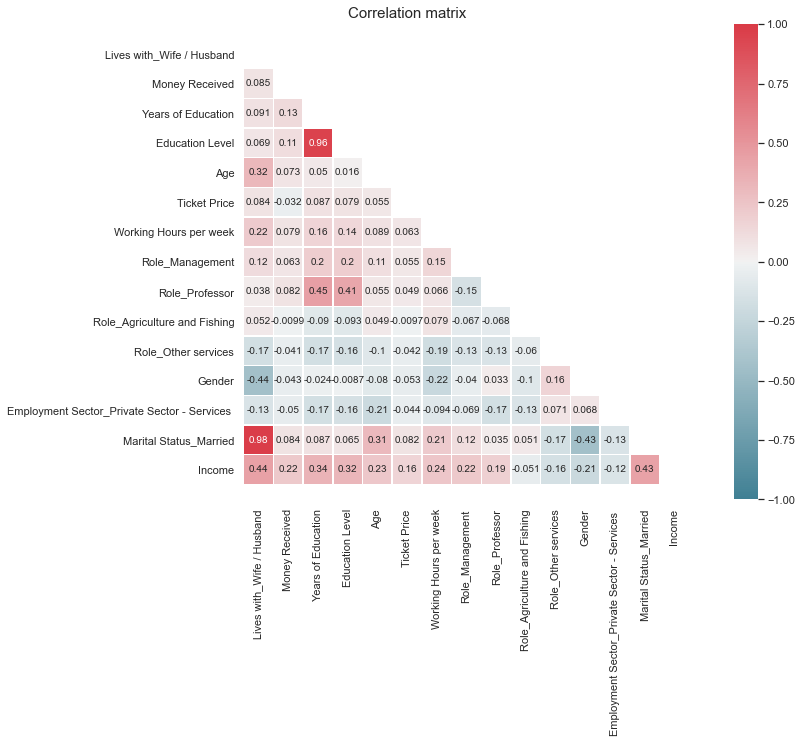

In [32]:
corrheatmap(newland_fs)

# Modeling

TRAIN TEST SPLIT

In [122]:
# TRAIN TEST SPLIT

X = newland_fs.drop(['Income'], axis=1)
Y = newland_fs['Income']

# hold-out method
X_train, X_validation,y_train, y_validation = train_test_split(X,Y,train_size = 0.80, shuffle = True, stratify = Y)


# Standardization of the variables with the robust scaler
robust = RobustScaler().fit(X_train)
X_train_robust = pd.DataFrame(robust.transform(X_train), columns=X_train.columns, index = X_train.index)
X_validation_robust = pd.DataFrame(robust.transform(X_validation), columns=X_validation.columns, index = X_validation.index)

X_train = X_train_robust
X_validation = X_validation_robust

In [123]:
# Gradient Boosting

gb_model = GradientBoostingClassifier(ccp_alpha= 0,
                                    criterion= 'friedman_mse',
                                    learning_rate= 0.3,
                                    loss= 'deviance',
                                    min_samples_leaf= 5,
                                    min_samples_split= 2,
                                    n_estimators= 135,
                                    random_state= 10)

gb_model.fit(X_train, y_train)
y_prediction = gb_model.predict(X_validation)  
GradientBoosting_F1 = round(f1_score(y_true = y_validation, y_pred = y_prediction, average='micro')*100, 3)
GradientBoosting_F1

86.676

In [135]:
prova = pd.concat([X_validation.reset_index(), pd.Series(y_prediction), y_validation.reset_index()], axis = 1)

In [136]:
prova

,CITIZEN_ID,Lives with_Wife / Husband,Money Received,Years of Education,Ticket Price,Age,Working Hours per week,Role_Management,Role_Professor,Role_Agriculture and Fishing,Gender,Employment Sector_Self-Employed (Individual),Role_Other services,0,CITIZEN_ID,Income
0,20558.0,0.0,0.0,0.00,0.0,-0.50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20558.0,0.0
1,18336.0,1.0,0.0,0.00,0.0,0.25,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18336.0,1.0
2,29082.0,0.0,0.0,0.75,0.0,-0.40,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,29082.0,0.0
3,22594.0,0.0,0.0,-0.25,0.0,0.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,22594.0,0.0
4,14605.0,0.0,0.0,-0.25,0.0,-0.30,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,14605.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3500,19855.0,0.0,0.0,-0.25,0.0,-0.30,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,19855.0,0.0
3501,26109.0,0.0,0.0,0.75,0.0,-0.40,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,26109.0,1.0
3502,14678.0,0.0,0.0,0.00,0.0,-0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14678.0,0.0
3503,23275.0,1.0,0.0,0.00,0.0,0.05,6.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23275.0,0.0


Balance of the predictions

In [137]:
prova = prova.rename(columns={0: "prediction"})

<Figure size 720x576 with 0 Axes>

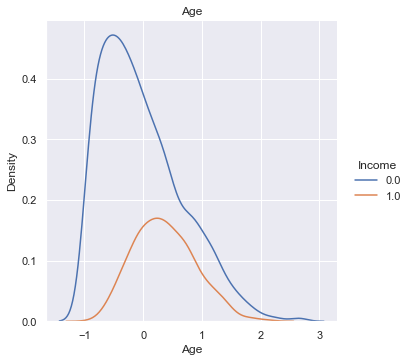

In [138]:
plt.figure(figsize=(10, 8))
sns.displot(prova, x='Age', kind="kde", hue='Income')
plt.title('Age')
plt.show()

<Figure size 720x576 with 0 Axes>

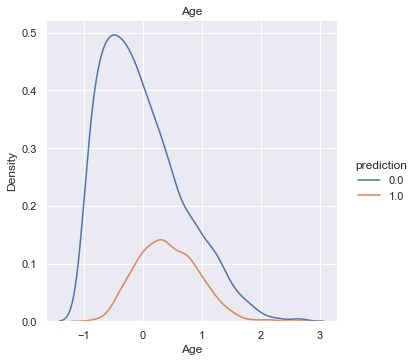

In [139]:
plt.figure(figsize=(10, 8))
sns.displot(prova, x='Age', kind="kde", hue='prediction')
plt.title('Age')
plt.show()

In [141]:
prova['Income'] = prova['Income'].astype(int)
prova['prediction'] = prova['prediction'].astype(int)

In [142]:
confusion_matrix(prova.Income, prova.prediction)

array([[2516,  151],
       [ 316,  522]], dtype=int64)

C:\Users\lorep\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


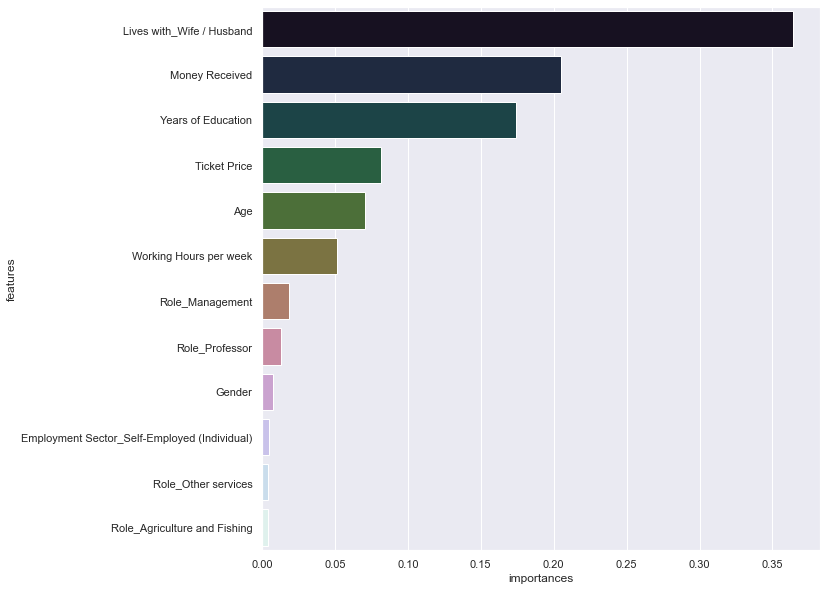

In [23]:
# Feature importances by GB
importances = gb_model.feature_importances_
features = X_train.columns
data_tuples = list(zip(importances, features))
data = pd.DataFrame(data_tuples, columns = ['importances', 'features'])
data = data.sort_values('importances', ascending = False)
sns.barplot(data['importances'], data['features'], palette = 'cubehelix', orient = 'h')
sns.set(rc={'figure.figsize':(10,10)})

Cross validation

In [538]:
# CROSS VALIDATION

X = newland_fs.drop(['Income'], axis=1)
Y = newland_fs['Income']

# Standardization of the variables with the robust scaler
robust = RobustScaler().fit(X)
X_robust = pd.DataFrame(robust.transform(X), columns=X.columns, index = X.index)
X = X_robust

# Gradient Boosting

In [59]:
# Model

gb_model = GradientBoostingClassifier(ccp_alpha= 0,
                                    criterion= 'friedman_mse',
                                    learning_rate= 0.3,
                                    loss= 'deviance',
                                    min_samples_leaf= 5,
                                    min_samples_split= 2,
                                    n_estimators= 135,
                                    random_state= 10)

In [60]:
# Score

kf = StratifiedKFold(n_splits=10)
avg_score(gb_model,kf, X, Y)

Train: 0.8789902384670436
Test: 0.8683380024328808


# Test - set

In [63]:
X_test_GB = X_test.copy()

In [64]:
feature_selection = ['Lives with_Wife / Husband',
 'Money Received',
 'Years of Education',
 'Ticket Price',
 'Age',
 'Working Hours per week',
 'Role_Management',
 'Role_Professor',
 'Role_Agriculture and Fishing',
 'Gender',
 'Employment Sector_Self-Employed (Individual)',
 'Role_Other services']

In [65]:
# Features selected with RFE 

X_test_GB = X_test_GB[feature_selection]


# Standardization of the variables with the robust scaler
robust = RobustScaler().fit(X_test_GB)
X_test_robust = pd.DataFrame(robust.transform(X_test_GB), columns=X_test_GB.columns, index = X_test_GB.index)
X_test_GB = X_test_robust

In [66]:
# Testing for the Test set the model previously created (trained with the train)
# 
#  feature RFE, robust scaler, trained on cross validation
y_prediction = gb_model.predict(X_test_GB)  
HistGradient_F1 = round(f1_score(y_true = y_test, y_pred = y_prediction, average='micro')*100, 3)
HistGradient_F1

86.138

# Tuning the parameters

In [51]:
def calculate_f1(interval, x_train, x_test, y_train, y_test, parameter):
    train_results = []
    test_results = []
    for value in interval:
        if parameter == 'Number of estimators':
            dt = GradientBoostingClassifier(ccp_alpha= 0,
                                    criterion= 'friedman_mse',
                                    learning_rate= 0.5,
                                    loss= 'deviance',
                                    min_samples_leaf= 5,
                                    min_samples_split= 2,
                                    n_estimators= value,
                                    random_state= 10)
        elif parameter == 'Learning Rate':
            dt = GradientBoostingClassifier(ccp_alpha= 0,
                                    criterion= 'friedman_mse',
                                    learning_rate= value,
                                    loss= 'deviance',
                                    min_samples_leaf= 5,
                                    min_samples_split= 2,
                                    n_estimators= 100,
                                    random_state= 10)
        dt.fit(x_train, y_train)
        train_results.append(f1_score(y_train,dt.predict(x_train), average='micro'))
        test_results.append(f1_score(y_test,dt.predict(x_test), average='micro'))
    value_train = train_results.index(max(train_results))
    value_test = test_results.index(max(test_results))
    print('The best train value is ',interval[value_train])
    print('The best test value is ',interval[value_test])

    fig = plt.figure(figsize = (16,10))
    line1, = plt.plot(interval, train_results, '#515C60', label="Train F1", linewidth=3)
    line2, = plt.plot(interval, test_results, '#C7DC1F', label="Test F1", linewidth=3)
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel("F1 score")
    plt.xlabel(str(parameter))
    plt.show()

The best train value is  246
The best test value is  134


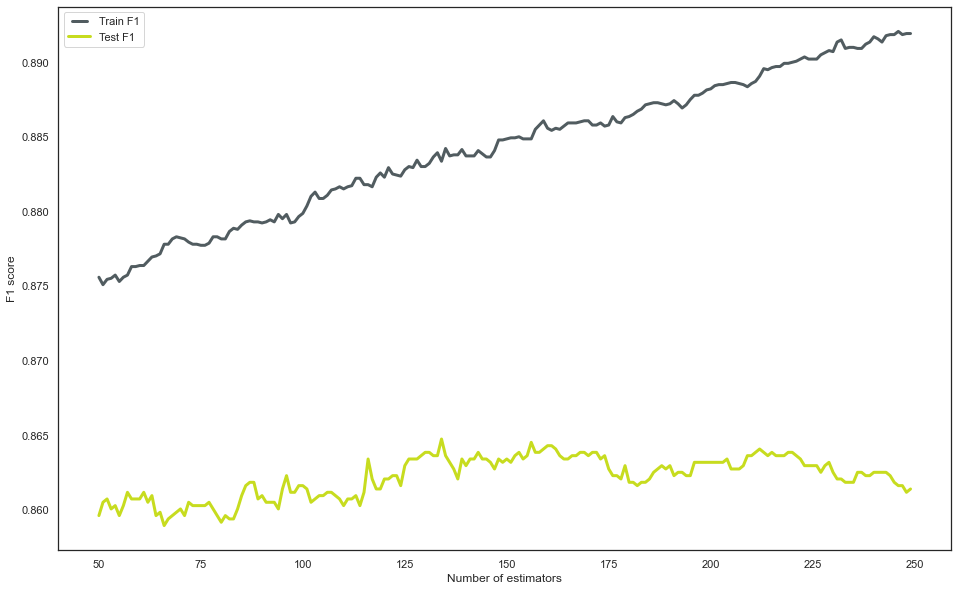

In [57]:
num_estimators = list(range(50,250))
calculate_f1(num_estimators, X_train, X_test_GB, y_train, y_test,'Number of estimators')

The best train value is  0.7000000000000001
The best test value is  0.30000000000000004


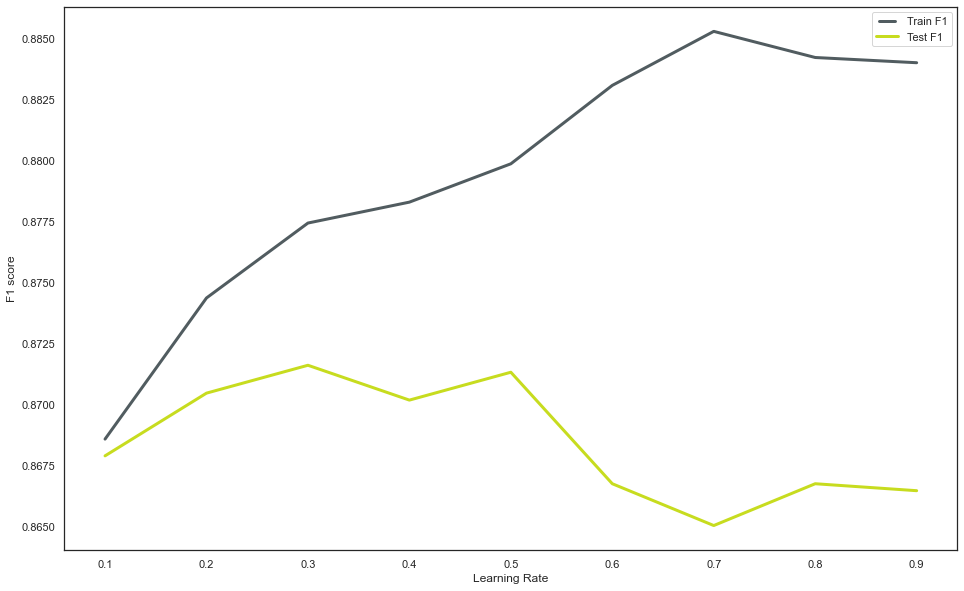

In [58]:
learning_rate = list(np.linspace(0.1, 0.9, 9, endpoint=True))
calculate_f1(learning_rate, X_train, X_validation, y_train, y_validation,'Learning Rate')

In [80]:
gb_model_2 = GradientBoostingClassifier(learning_rate= 0.5,
                                    n_estimators= 300,
                                    random_state= 5)

In [81]:
gb_model_2.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.5, n_estimators=300, random_state=5)

In [82]:
y_pred_2 = gb_model_2.predict(X_test_GB)

In [83]:
metrics(y_test, y_prediction, y_test, y_pred_2)

___________________________________________________________________________________________________________
                                              Model 1                                                      
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4272
           1       0.75      0.60      0.67      1328

    accuracy                           0.86      5600
   macro avg       0.81      0.77      0.79      5600
weighted avg       0.85      0.86      0.85      5600

___________________________________________________________________________________________________________
                                              Model 2                                                      
-----------------------------------------------------------------------------------------------------------
              precision  

# Prediction for Kaggle

In [456]:
test = pd.read_excel('Test.xlsx')

# for the test set
newland = test.copy()

In [457]:
newland['Gender'] = newland['Name'].str.split(n=2,expand=True).rename(columns={0:'Gender'}).drop(columns=[1,2])
newland['Gender'] = newland['Gender'].replace('Mr.', 0)
newland['Gender'] = newland['Gender'].replace('Mrs.', 1)
newland['Gender'] = newland['Gender'].replace('Miss', 1)

newland['year_of_birth'] = newland['Birthday'].map(lambda x: int(x[-4:]))
newland['Age'] = newland['year_of_birth'].map(lambda x: 2048 - x)
del newland['year_of_birth']

del newland['Name']
del newland['Birthday']

In [458]:
# Creating a copy of the dataset
newland_labels = newland.copy()


# Encoding the variable Education Level manually (it will be numerical because it's categorical but ordinal)
newland_labels['Education Level'] = newland_labels['Education Level'].replace(['Preschool',
'Primary School',
'Middle School - 1st Cycle',
'Middle School - 2nd Cycle',
'Middle School Complete',
'High School - 1st Cycle',
'High School - 2nd Cycle',
'Professional School',
'High School Complete',
'Professional School + PostGraduation',
'High School + PostGraduation',
'Bachelors',
'Bachelors + PostGraduation',
'Masters',
'Masters + PostGraduation',
'PhD'],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

# Encoding manually
# Replacing the values in some labels manually

newland_labels['Native Continent'] = newland_labels['Native Continent'].replace(['Asia', 'America', 'Oceania'], 'Other')

newland_labels['Marital Status'] = newland_labels['Marital Status'].replace(['Married - Spouse Missing', 'Separated', 'Widow', 'Married - Spouse in the Army'], 'Other')

newland_labels['Lives with'] = newland_labels['Lives with'].replace(['Wife', 'Husband'], 'Wife / Husband')

newland_labels['Base Area'] = newland_labels['Base Area'].replace(['Auchenshuggle', 'Sharnwick', 'Laewaes',
       'MillerVille', 'Fanfoss', 'Wigston', 'Aerilon', 'Watford',
       "Knife's Edge", 'Lanercost', 'Bellmoral', 'Bellenau', 'Butterpond',
       'Laenteglos', 'Tranmere', 'Eelry', 'Alverton', 'Pran', 'Willesden',
       "King's Watch", 'Kald', 'Kirkwall', "Fool's March",
       'Middlesbrough', 'Orilon', 'Aroonshire', 'Aberuthven', 'Lewes',
       'Marnmouth', 'Mensfield', 'Sharpton', 'Cherrytown', 'Redwick Bush',
       'Drumchapel', 'Carlisle', 'Conriston', 'Woodpine', 'Ironforge'], 'Other')

newland_labels['Employment Sector'] = newland_labels['Employment Sector'].replace(['Private Sector - Others',
       'Self-Employed (Company)', 'Public Sector - Government',
       'Unemployed', 'Never Worked'], 'Other')


newland = newland_labels.copy()

In [303]:
# checking for the missing values with the ?

# Replacing the '?' value with np.nan
newland = newland.replace('?', np.nan)

newland.isna().sum()


CITIZEN_ID                  0
Native Continent            0
Marital Status              0
Lives with                  0
Base Area                 187
Education Level             0
Years of Education          0
Employment Sector         570
Role                      570
Working Hours per week      0
Money Received              0
Ticket Price                0
Gender                      0
Age                         0
dtype: int64

In [304]:
# Replacing the missing values with the mode for Base Area

newland['Base Area'] = newland['Base Area'].replace(np.nan, newland['Base Area'].mode()[0])
newland['Employment Sector'] = newland['Employment Sector'].replace(np.nan, newland['Employment Sector'].mode()[0])
newland['Role'] = newland['Role'].replace(np.nan, newland['Role'].mode()[0])

In [459]:
# one hot encoder

newland_ohc = newland.copy()


# Updating metric and non-metric features
# Education level now is a metric feature
metric_features = ['Years of Education','Working Hours per week', 'Education Level','Money Received','Ticket Price', 'Age', 'Sex', 'Income']
non_metric_features = ['Native Continent','Marital Status','Lives with','Base Area','Employment Sector','Role']

ohc = OneHotEncoder(sparse=False)
ohc_feat = ohc.fit_transform(newland_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names(non_metric_features)
ohc_df = pd.DataFrame(ohc_feat, index=newland_ohc.index, columns=ohc_feat_names)

newland_ohc1 = pd.concat([newland_ohc.drop(columns=non_metric_features), ohc_df], axis=1)

newland = newland_ohc1.copy()

In [460]:
# Missing values
# 
# Defining the variables to change to nan (based on the ?)
Base_Area_to_replace = ['Base Area_Northbury','Base Area_Other']
Employment_Sector_to_replace = ['Employment Sector_Other','Employment Sector_Private Sector - Services ','Employment Sector_Public Sector - Others','Employment Sector_Self-Employed (Individual)']
Role_to_replace = ['Role_Administratives', 'Role_Agriculture and Fishing', 'Role_Army','Role_Cleaners & Handlers', 'Role_Household Services', 'Role_IT','Role_Machine Operators & Inspectors', 'Role_Management','Role_Other services', 'Role_Professor', 'Role_Repair & constructions','Role_Sales', 'Role_Security', 'Role_Transports']

# Defining the nan values
newland.loc[newland['Base Area_?'] == 1.0, Base_Area_to_replace] = np.nan
newland.loc[newland['Employment Sector_?'] == 1.0, Employment_Sector_to_replace] = np.nan
newland.loc[newland['Role_?'] == 1.0, Role_to_replace] = np.nan

# Dropping the variables with the question mark
newland.drop(columns=['Base Area_?','Employment Sector_?','Role_?'], inplace = True)


In [462]:
X_test = newland.copy()

In [463]:
# Setting the index in the dataset
X_test = X_test.set_index('CITIZEN_ID')

In [464]:
# Feature selection
# 
feature_selection = ['Lives with_Wife / Husband',
 'Money Received',
 'Years of Education',
 'Ticket Price',
 'Age',
 'Working Hours per week',
 'Role_Management',
 'Role_Professor',
 'Role_Agriculture and Fishing',
 'Gender',
 'Employment Sector_Self-Employed (Individual)',
 'Role_Other services']

X_test = X_test[feature_selection]

# Standardization of the variables with the robust scaler
robust = RobustScaler().fit(X_test)
X_test_robust = pd.DataFrame(robust.transform(X_test), columns=X_test.columns, index = X_test.index)
X_test = X_test_robust

In [465]:
y_prediction = gb_model.predict(X_test)  
y_prediction = y_prediction.astype(int)
X_test.index = X_test.index.astype(int)

In [468]:
submission = pd.DataFrame({'CITIZEN_ID': X_test.index, 'Income': y_prediction})

filename = 'prediction_2-Hist-GB.csv'
submission.to_csv(filename, index=False)

In [469]:
submission

,CITIZEN_ID,Income
0,34886,1
1,34887,0
2,34888,1
3,34889,0
4,34890,1
...,...,...
10095,44981,1
10096,44982,1
10097,44983,0
10098,44984,0
